# Предобработка данных

#### Подключение библиотек и скриптов

In [620]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# 4. Метирки качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

In [621]:
import warnings

warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [622]:
import datetime
now = datetime.datetime.now()

#### Пути к директориям и файлам

In [623]:
TRAIN_DATASET_PATH = 'C:\\GeekBrains\\Libraries_Python\\Real_estate_course\\realestatepriceprediction\\train.csv'
TEST_DATASET_PATH  = 'C:\\GeekBrains\\Libraries_Python\\Real_estate_course\\realestatepriceprediction\\test.csv'

# Шаг 1. Загрузка данных

In [624]:
# Оптимизация reduce_mem_usage

In [625]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

#### Загрузка данных

**Data fields**

* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

In [626]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
# train_df = reduce_mem_usage(train_df)
train_df.head()

test_df = pd.read_csv(TEST_DATASET_PATH)

Оптимизация reduce_mem_usage 

In [627]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

# Шаг 2. EDA и очистка данных

#### Оценка распредения целевой переменной в разрезе других признаков

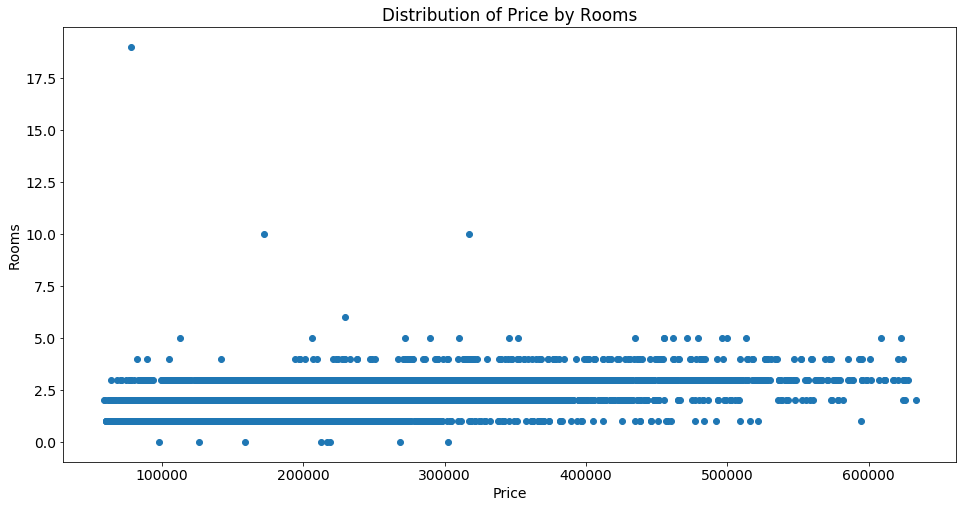

In [628]:
plt.figure(figsize=(16, 8))

plt.scatter(train_df['Price'], train_df['Rooms'])

plt.xlabel('Price')
plt.ylabel('Rooms')
plt.title('Distribution of Price by Rooms')
plt.show()

#### Анализ целевой переменной

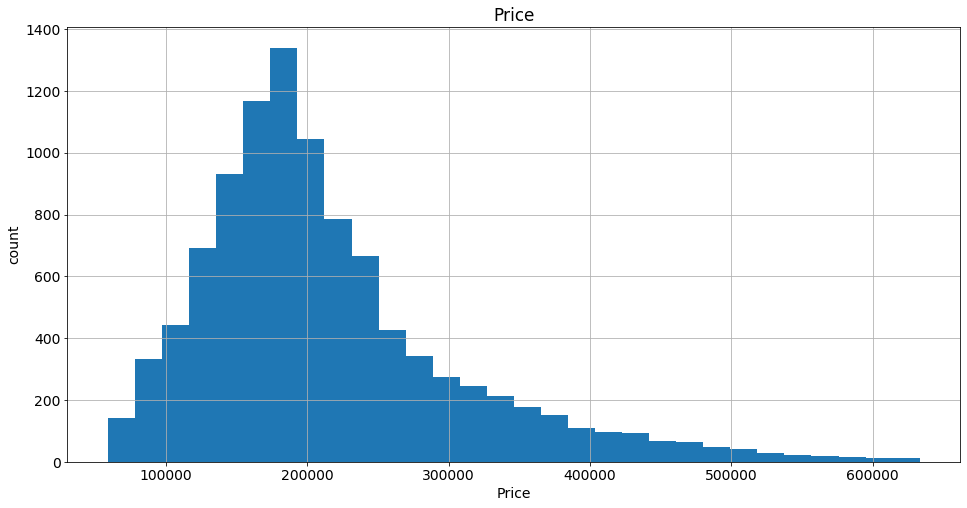

In [629]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('count')
plt.xlabel('Price')

plt.title('Price')
plt.show()

# Шаг 3: Очистка данных и Feature engineering

### Приведение типов данных

In [630]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [631]:
train_df['Id'] = train_df['Id'].astype(str)


### Обработка данных

In [632]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.medians = None

    def fit(self, df):
        """Сохранение статистик"""
        # Расчетет медиан
        self.LifeSquare_median = df['LifeSquare'].median()
        self.Square_median = df['Square'].median()
        self.Rooms_median  = df['Rooms'].median()
        self.HouseYear     = df['HouseYear'].median()
        
    def transform(self, df):
        # * Square - площадь
        # Оставляем записи где площадь больше 15
        # df = df[df.Square > 15] удалять записи нельзя
        df.loc[(df['Square'] > 280), 'Square'] = ((df.loc[(df['Square'] > 280), 'Square']) / 10)
        df.loc[(df['Square'] < 16), 'Square'] = ((df.loc[(df['Square'] < 16), 'Square']) * 10)

        
        # * LifeSquare - жилая площадь
        # Ищем процентное соотношение площади и жилой площади
        lsq_r =  self.LifeSquare_median / self.Square_median
        # Заполняем жилую площадь
        df.loc[(df['LifeSquare']== 0) | (df['LifeSquare'] < 6 ) | (df['LifeSquare'].isna()),'LifeSquare'] = df['Square']*lsq_r
        
        # * Rooms - количество комнат
        # Средняя площать комнаты
        sq_r = self.Square_median / self.Rooms_median
        # Заполняем комнаты как общая плщадь на среднюю площадь комнаты
        df.loc[(df['Rooms']==0) | (df['Rooms'] > 6), 'Rooms'] = df['Square']/sq_r
        df['Rooms'] = df['Rooms'].astype(int)
        
        # * Rooms - количество комнат
        # Оставляем записи где год актуальный
        # df = df[df.HouseYear < now.year]
        df.loc[df['HouseYear'] > now.year,'HouseYear'] = now.year
        
        # * Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
        median = df['Healthcare_1'].median()
        df.loc[(df['Healthcare_1']== 0) | (df['Healthcare_1'].isna()),'Healthcare_1'] = df['Healthcare_1'].fillna(median)
        
        # Отбор и построение новых признаков (фичей) 'Ecology_2', 'Ecology_3','Shops_2
        df = pd.get_dummies(df, columns=['Ecology_2', 'Ecology_3','Shops_2'])
        
        return df

In [633]:
pipe = DataPipeline()
pipe.fit(train_df) # расчет статисстик
train_df = pipe.transform(train_df)

In [634]:
train_df.head(100)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,14038,35,2,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,900.0,0,11,184966.930730,0,1,0,1,0,1
1,15053,41,3,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,240.0,1,16,300009.450063,0,1,0,1,0,1
2,4765,53,2,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,229.0,1,3,220925.908524,0,1,0,1,0,1
3,5809,58,2,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,1084.0,0,5,175616.227217,0,1,0,1,0,1
4,10783,99,1,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,2078.0,2,4,150226.531644,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,4280,34,2,61.334968,38.288151,1.0,26,1.0,2014,0.069753,...,900.0,1,11,286564.441972,0,1,0,1,0,1
96,14319,27,2,58.937280,34.740070,11.0,2,7.0,1998,0.041116,...,900.0,1,4,217349.256589,0,1,0,1,0,1
97,13671,84,3,63.728237,38.960935,6.0,9,9.0,1971,0.149666,...,4087.0,4,1,291058.080899,0,1,0,1,0,1
98,9753,23,1,41.845698,26.122039,1.0,14,17.0,1977,0.075779,...,900.0,0,2,110620.629320,0,1,0,1,0,1


In [635]:
train_df.sort_values(by='Square')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
6392,14786,1,1,11.368588,7.096803,1.0,3,1.0,1977,0.007122,...,900.0,0,1,181434.825589,0,1,0,1,0,1
7767,6927,21,1,16.117154,8.822988,0.0,2,5.0,1965,0.194489,...,125.0,3,5,79913.267856,0,1,0,1,0,1
5617,15877,57,3,16.547242,16.698571,8.0,5,5.0,1962,0.133215,...,1406.0,3,4,77835.185808,0,1,0,1,1,0
3166,15127,150,1,17.046188,20.036232,8.0,7,12.0,1982,0.300323,...,900.0,1,9,74222.110465,0,1,0,1,0,1
6945,12927,62,2,17.414181,10.870745,1.0,4,20.0,1977,0.072158,...,900.0,0,0,180750.471749,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652,3718,56,3,190.857689,107.376164,19.0,7,3.0,2007,0.000000,...,900.0,2,6,338644.075979,0,1,0,1,0,1
8511,4249,23,5,198.930182,123.139863,10.0,1,2.0,2011,0.014073,...,900.0,0,0,345665.209100,0,1,0,1,0,1
9910,16568,27,4,200.334539,201.627361,25.0,1,2.0,2013,0.041116,...,900.0,1,4,528560.506016,0,1,0,1,0,1
1981,7917,27,8,212.932361,211.231125,0.0,2,3.0,2008,0.211401,...,900.0,0,1,302211.260887,0,1,0,1,0,1


### Отбор и построение новых признаков (фичей)

#### Оставим признаки, которые необходимы для модели

In [636]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Price',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B']

In [637]:
feature_names = [
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B']

target_name = 'Price'

In [638]:
train_df = train_df[feature_names + [target_name]]
train_df.head(4)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Social_3,Healthcare_1,Helthcare_2,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,Price
0,35,2,47.981561,29.442751,6.0,7,9.0,1969,0.089040,33,...,5,900.0,0,0,1,0,1,0,1,184966.930730
1,41,3,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,...,1,240.0,1,0,1,0,1,0,1,300009.450063
2,53,2,44.947953,29.197612,0.0,8,12.0,1968,0.049637,34,...,0,229.0,1,0,1,0,1,0,1,220925.908524
3,58,2,53.352981,52.731512,9.0,8,17.0,1977,0.437885,23,...,3,1084.0,0,0,1,0,1,0,1,175616.227217


### Сохранение  датасета

In [639]:
# DATASET_PATH = 'C:\\GeekBrains\\Libraries_Python\\Real_estate_course\\realestatepriceprediction\\train.csv'
# df.to_csv(DATASET_PATH, index=False, encoding='utf-8')

# Шаг 4. Разбиение на train / test

In [640]:
X = train_df[feature_names]
y = train_df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

# Шаг 5. Построение моделей

Бизнес метрика - R^2, Root Mean Squared Error (RMSE)

In [641]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

### 5.3 Random Forest

R2:	0.843
RMSE:	36780.38
MSE:	1352796321.929


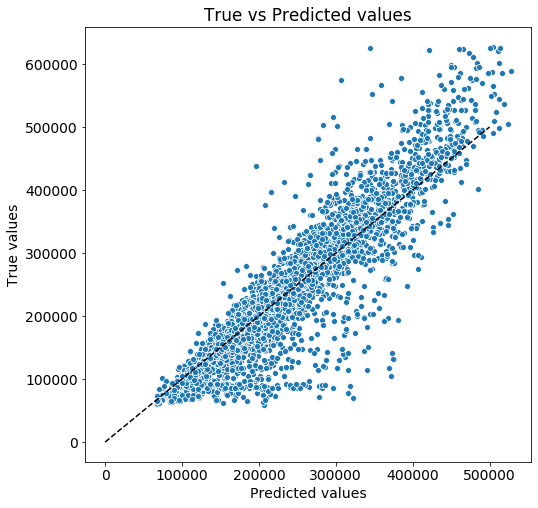

In [642]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=18, # глубина дерева  
                                 min_samples_leaf=7, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42,
                                
                                n_estimators=1422 # кол-во деревьев
                                )

rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

#### RandomForestRegressor, найдите информацию об атрибуте feature_importances_. С помощью этого атрибута найдите сумму всех показателей важности, установите, какие два признака показывают наибольшую важность.

In [643]:
from sklearn.ensemble import RandomForestRegressor

In [644]:
clf = RandomForestRegressor(n_estimators=1000, max_depth = 12, random_state = 42 )

In [645]:
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=12, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [646]:
importance = clf.feature_importances_

In [647]:
feature_importance = pd.DataFrame({'feature_names':X.columns, 
                                   'feature_importance':importance}, 
                                  columns=['feature_importance', 'feature_names'])

In [648]:
feature_importance.sort_values(by="feature_importance", ascending=False, inplace=True)

In [649]:
feature_importance.head

<bound method NDFrame.head of     feature_importance  feature_names
2             0.410767         Square
9             0.110854       Social_1
10            0.094742       Social_2
1             0.078887          Rooms
11            0.063224       Social_3
0             0.048530     DistrictId
8             0.041742      Ecology_1
7             0.028699      HouseYear
3             0.028122     LifeSquare
5             0.024465          Floor
12            0.023767   Healthcare_1
4             0.021202  KitchenSquare
6             0.017592     HouseFloor
13            0.005246    Helthcare_2
17            0.000409    Ecology_3_B
16            0.000400    Ecology_3_A
18            0.000379      Shops_2_A
19            0.000368      Shops_2_B
15            0.000346    Ecology_2_B
14            0.000260    Ecology_2_A>

### Расчет цены для тестовых данных

In [650]:
test_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A


In [651]:
pipe = DataPipeline()
pipe.fit(test_df) # расчет статисстик
test_df = pipe.transform(test_df)

In [652]:
test_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,725,58,2,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,1,900.0,0,0,0,1,0,1,0,1
1,15856,74,2,69.263183,43.092188,1.0,6,1.0,1977,0.075779,...,3,900.0,0,2,0,1,0,1,0,1
2,5480,190,1,135.978185,15.948246,12.0,2,5.0,1909,0.000000,...,87,4702.0,5,5,0,1,0,1,0,1
3,15664,47,2,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,3,900.0,3,3,0,1,0,1,0,1
4,14275,27,1,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,1,900.0,0,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3,67.133911,50.809797,6.0,5,9.0,1973,0.000170,...,0,900.0,1,1,0,1,0,1,0,1
4996,4695,1,1,40.198472,21.807061,10.0,12,17.0,2017,0.007122,...,0,900.0,0,1,0,1,0,1,0,1
4997,5783,12,3,77.842178,48.282625,9.0,23,22.0,1989,0.090799,...,2,900.0,5,15,0,1,0,1,0,1
4998,4780,62,2,81.305222,50.584159,0.0,4,0.0,1977,0.072158,...,1,900.0,0,0,0,1,0,1,1,0


### Создаем датафрейм с предсказаниями модели

In [653]:
X_final = test_df

preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

X_final.set_index('Id', inplace=True)
X_final = X_final[feature_names]

#### Выгружаем предсказания в файл

In [654]:
y_pred_final = rf_model.predict(X_final)

preds_final['Price'] = y_pred_final
preds_final.to_csv('C:\\GeekBrains\\Libraries_Python\\Real_estate_course\\realestatepriceprediction\\predictions.csv', index=False, encoding='utf-8', sep=',')

preds_final.head(5000)

,Id,Price
0,725,159901.135293
1,15856,213800.823331
2,5480,366160.731848
3,15664,353939.882079
4,14275,140335.885940
...,...,...
4995,8180,243987.635812
4996,4695,125169.453585
4997,5783,323868.130836
4998,4780,204385.660483
